In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

In [9]:
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image = 'person.jpg'

# image preprocess (to Tensor)
image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

image_tensor = preprocess(image).unsqueeze(0)

print(image_tensor.shape)

torch.Size([1, 3, 224, 224])


In [6]:
#image test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)

model.eval()

image_tensor = image_tensor.to(device)

with torch.no_grad():
    output = model(image_tensor)

_, predict = torch.max(output,1)

predict_label = idx2label[predict.item()]

In [17]:
print(predict)

tensor([981], device='cuda:0')


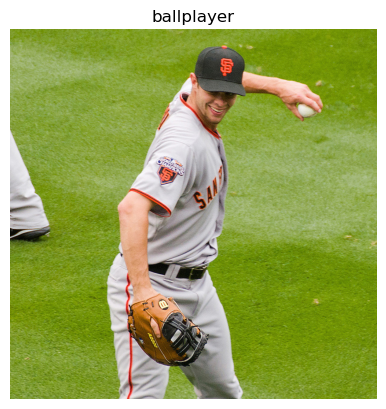

In [12]:
# test result's output

# Preprocessing & Tensor -> CPU 해상도 떨어짐?
# image_vis = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.axis("off")
plt.title(predict_label)
plt.show()

### FGSM 
- 학습 시 기울기 방향 == 손실이 증가하는 방향
    - 방향성을 알 수 있는 sign() 함수 사용

In [18]:
def fgsm(epsilon, image, gradient):
    sign_gradient = gradient.sign()

    adversarial_image = image + epsilon*sign_gradient

    return adversarial_image

image_tensor.requires_grad_(True)
output = model(image_tensor)

loss = nn.CrossEntropyLoss(output, predict)

model.zero_grad()
loss.backward()

gradient = image_tensor.grad.data

epsilon = 0.03
adversarial_image = fgsm(epsilon, image_tensor, gradient)

adversarial_output = model(adversarial_image)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

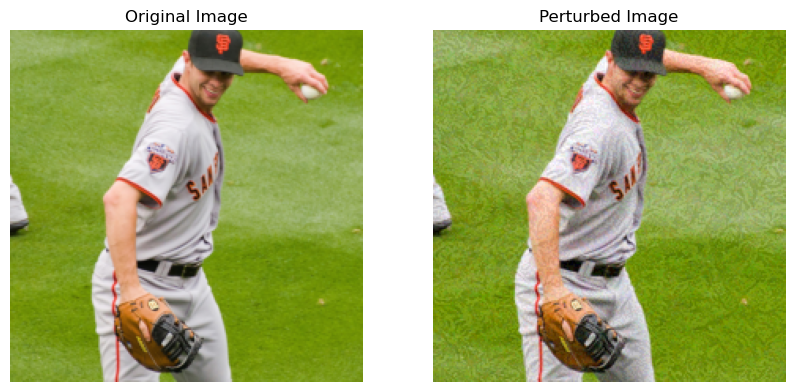

In [22]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

def fgsm(epsilon, image, gradient):
    sign_gradient = gradient.sign()
    adversarial_image = image + epsilon * sign_gradient
    return adversarial_image

# 모델 로드 및 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

# 입력 데이터와 라벨 설정
input_image = 'person.jpg'
image = Image.open(input_image).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
image_tensor = preprocess(image).unsqueeze(0).to(device)
labels = torch.tensor([0]).to(device)  # 임의의 라벨 (여기서는 임의로 0으로 설정)

# 기울기 계산을 위해 requires_grad_ 설정
image_tensor.requires_grad = True

# 모델 예측 및 손실 계산
output = model(image_tensor)
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(output, labels)

# 기울기 계산
model.zero_grad()
loss.backward()

# 기울기 추출
gradient = image_tensor.grad.data

# FGSM 공격 수행
epsilon = 0.03
adversarial_image = fgsm(epsilon, image_tensor, gradient)

# 적대적 예제에 대한 모델 예측
adversarial_output = model(adversarial_image)

# 적대적 예제 시각화 (옵션)
import matplotlib.pyplot as plt
import numpy as np

# 원본 이미지
original_image = image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image = np.clip(original_image, 0, 1)

# 변형된 이미지
perturbed_image = adversarial_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
perturbed_image = np.clip(perturbed_image, 0, 1)

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(original_image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(perturbed_image)
ax2.set_title('Perturbed Image')
ax2.axis('off')

plt.show()